In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("data_7days.csv", parse_dates=["time"])
df = df.sort_values(by=["time", "x", "y"])
features = ["dust", "temp", "humidity", "MQ2", "MQ7"]

timestamps = df["time"].unique()
X_tensor = []
for t in timestamps:
    snapshot = df[df["time"] == t][features].values.reshape(5, 5, -1)
    X_tensor.append(snapshot)
X_tensor = np.array(X_tensor)
print("✅ Dữ liệu tensor:", X_tensor.shape)


✅ Dữ liệu tensor: (34559, 5, 5, 5)


In [3]:
def create_sequence_data(X_tensor, seq_len, future_step):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(X_tensor.reshape(X_tensor.shape[0], -1))
    scaled = scaled.reshape(X_tensor.shape)
    X_seq, y_seq = [], []
    for i in range(len(scaled) - seq_len - future_step):
        X_seq.append(scaled[i:i+seq_len])
        y_seq.append(scaled[i+seq_len+future_step-1])
    return np.array(X_seq), np.array(y_seq), scaler


In [4]:
def train_evaluate_model(name, model, X_train, y_train, X_val, y_val):
    print(f"\n🔧 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f"📊 {name} RMSE: {rmse:.4f}")
    return rmse, model


In [5]:
def train_lstm(X_seq, y_seq, name="LSTM"):
    X_seq = X_seq.reshape(X_seq.shape[0], X_seq.shape[1], -1)
    y_seq = y_seq.reshape(y_seq.shape[0], -1)
    X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=X_train.shape[1:], kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    print(f"\n🔧 Training {name}...")
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[es], verbose=1)
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f"📊 {name} RMSE: {rmse:.4f}")
    return rmse, model, scaler, X_val, y_val, y_pred


In [6]:
def train_cnn_lstm(X_seq, y_seq, name="CNN-LSTM"):
    X_seq = X_seq.reshape(X_seq.shape[0], X_seq.shape[1], 5, 5, 5)  # (samples, timesteps, 5, 5, features)
    y_seq = y_seq.reshape(y_seq.shape[0], -1)
    X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    model = Sequential()
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=X_train.shape[1:]))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(y_train.shape[1]))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    print(f"\n🔧 Training {name}...")
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[es], verbose=1)
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    print(f"📊 {name} RMSE: {rmse:.4f}")
    return rmse, model, scaler, X_val, y_val, y_pred


In [7]:
future_steps = [10, 40, 80, 160]
results_dict = {}

for future_step in future_steps:
    print(f"\n================ FUTURE STEP = {future_step} (~{future_step*15//60} phút) ================")

    X = X_tensor[:-future_step]
    y = X_tensor[future_step:]
    X_flat = X.reshape(X.shape[0], -1)
    y_flat = y.reshape(y.shape[0], -1)
    X_train, X_temp, y_train, y_temp = train_test_split(X_flat, y_flat, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    models = {
        "LinearRegression": LinearRegression(),
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
    }

    rmses = {}
    best_rmse = float("inf")
    best_model = None
    best_name = ""

    for name, model in models.items():
        rmse, trained = train_evaluate_model(name, model, X_train, y_train, X_val, y_val)
        rmses[name] = rmse
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = trained
            best_name = name

    # LSTM
    X_seq, y_seq, scaler = create_sequence_data(X_tensor, seq_len=10, future_step=future_step)
    try:
        rmse_lstm, model_lstm, lstm_scaler, X_lstm_val, y_lstm_val, y_lstm_pred = train_lstm(X_seq, y_seq)
        rmses["LSTM"] = rmse_lstm
        if rmse_lstm < best_rmse:
            best_rmse = rmse_lstm
            best_model = model_lstm
            best_name = "LSTM"
            last_scaler = lstm_scaler
            last_y_true = y_lstm_val
            last_y_pred = y_lstm_pred
    except Exception as e:
        print(f"LSTM failed: {e}")

    # CNN-LSTM
    try:
        rmse_cnn, model_cnn, cnn_scaler, X_cnn_val, y_cnn_val, y_cnn_pred = train_cnn_lstm(X_seq, y_seq)
        rmses["CNN-LSTM"] = rmse_cnn
        if rmse_cnn < best_rmse:
            best_rmse = rmse_cnn
            best_model = model_cnn
            best_name = "CNN-LSTM"
            last_scaler = cnn_scaler
            last_y_true = y_cnn_val
            last_y_pred = y_cnn_pred
    except Exception as e:
        print(f"CNN-LSTM failed: {e}")

    results_dict[future_step] = rmses
    print(f"✅ Best model for future_step={future_step}: {best_name} with RMSE={best_rmse:.4f}")
    joblib.dump(best_model, f"best_model_{future_step}_{best_name}.pkl")



================ FUTURE STEP = 10 (~2 phút) ================

🔧 Training LinearRegression...
📊 LinearRegression RMSE: 2.9769

🔧 Training RandomForest...
📊 RandomForest RMSE: 2.9424

🔧 Training LSTM...
Epoch 1/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.1225 - mae: 0.1061 - val_loss: 0.0055 - val_mae: 0.0383
Epoch 2/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0058 - mae: 0.0404 - val_loss: 0.0049 - val_mae: 0.0340
Epoch 3/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0054 - mae: 0.0382 - val_loss: 0.0043 - val_mae: 0.0243
Epoch 4/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0051 - mae: 0.0366 - val_loss: 0.0048 - val_mae: 0.0326
Epoch 5/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0052 - mae: 0.0373 - val_loss: 0.0051 - val_mae: 0.0354
Epoch 6/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0050 - mae: 0.0359 - val_loss: 0.0047 - val_mae: 0.0332
Epoch 7/50
756/756 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0050 - mae: 0.0360 - val_los

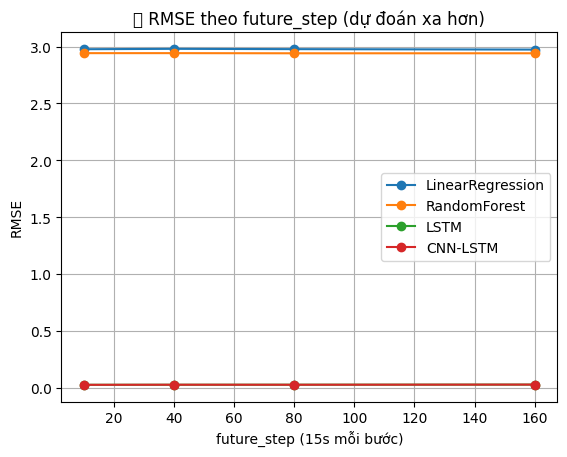

In [8]:
for model in ["LinearRegression", "RandomForest", "LSTM", "CNN-LSTM"]:
    values = [results_dict[fs].get(model, None) for fs in future_steps]
    plt.plot(future_steps, values, marker='o', label=model)

plt.title("📈 RMSE theo future_step (dự đoán xa hơn)")
plt.xlabel("future_step (15s mỗi bước)")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()


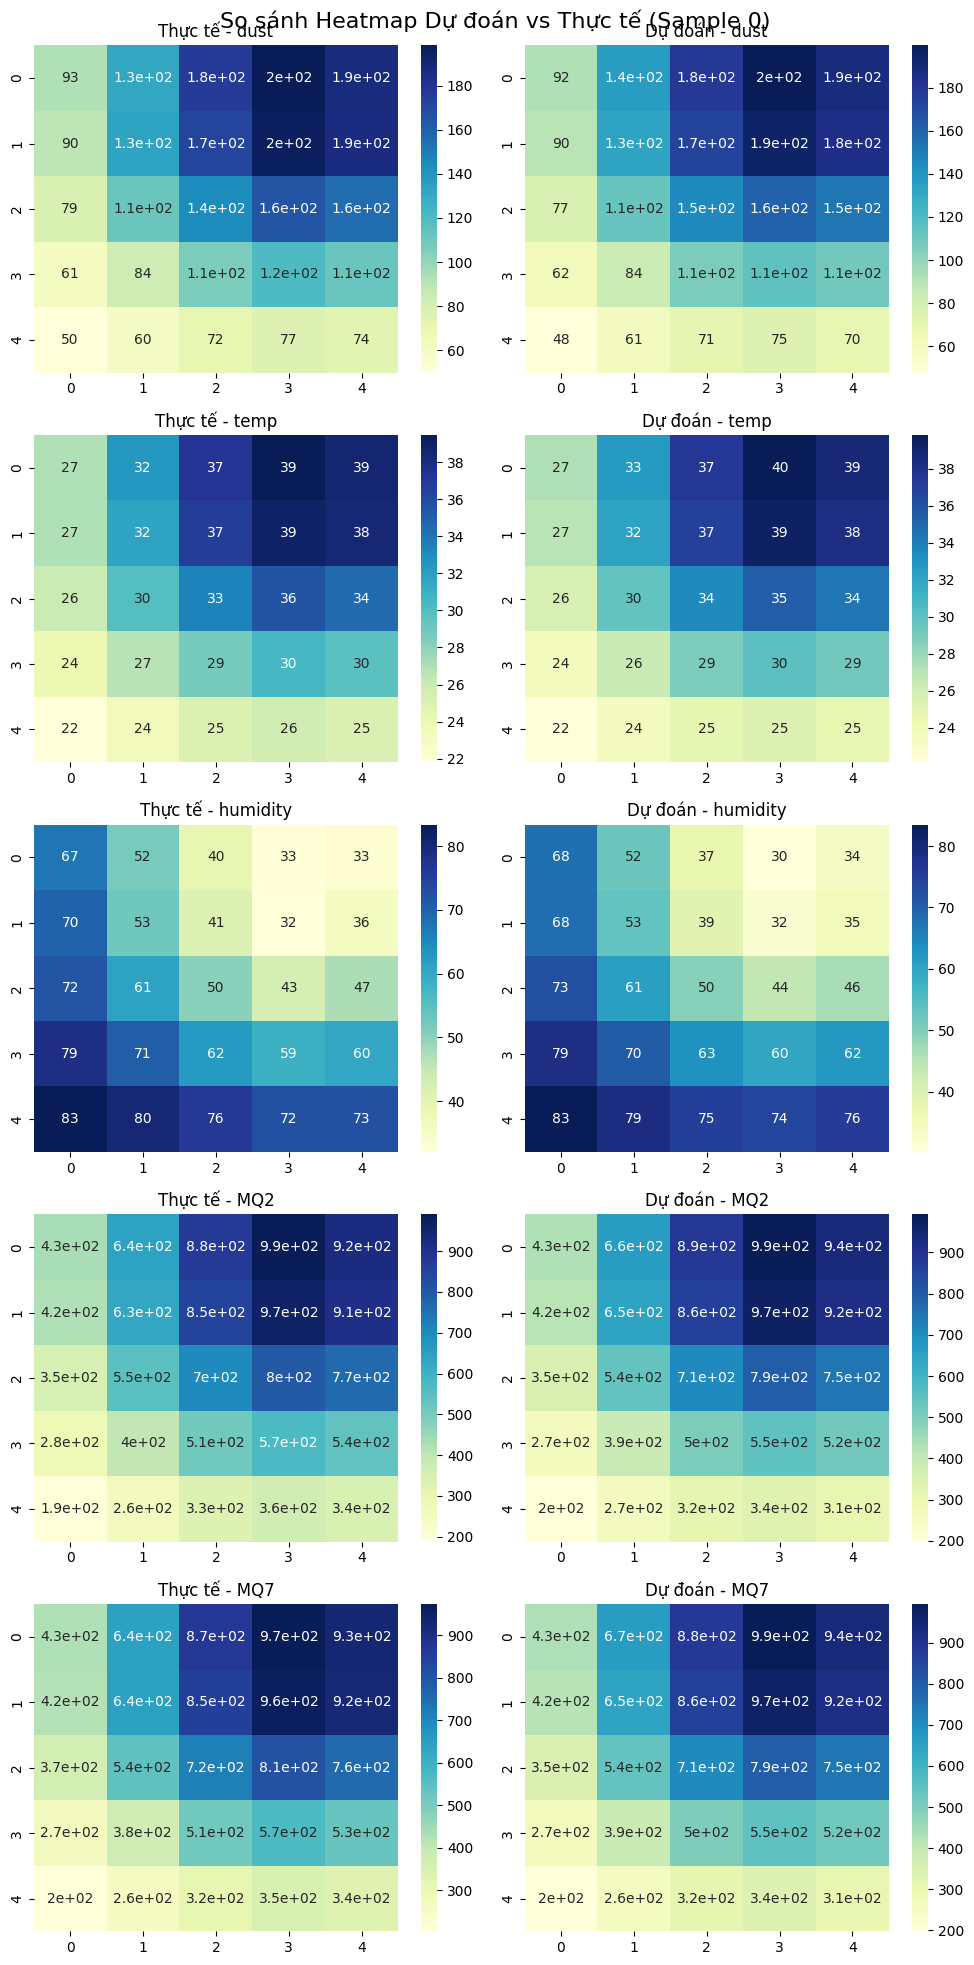

In [9]:
def plot_heatmap_comparison(y_true, y_pred, sample_idx=0):
    feature_names = ["dust", "temp", "humidity", "MQ2", "MQ7"]
    fig, axs = plt.subplots(5, 2, figsize=(10, 20))
    fig.suptitle(f"So sánh Heatmap Dự đoán vs Thực tế (Sample {sample_idx})", fontsize=16)

    for i in range(5):
        true_grid = y_true[sample_idx][i::5].reshape(5, 5)
        pred_grid = y_pred[sample_idx][i::5].reshape(5, 5)

        sns.heatmap(true_grid, ax=axs[i, 0], cmap="YlGnBu", annot=True)
        axs[i, 0].set_title(f"Thực tế - {feature_names[i]}")
        
        sns.heatmap(pred_grid, ax=axs[i, 1], cmap="YlGnBu", annot=True)
        axs[i, 1].set_title(f"Dự đoán - {feature_names[i]}")

    plt.tight_layout()
    plt.show()

if 'last_scaler' in globals():
    y_true_inv = last_scaler.inverse_transform(last_y_true)
    y_pred_inv = last_scaler.inverse_transform(last_y_pred)
    plot_heatmap_comparison(y_true_inv, y_pred_inv, sample_idx=0)


In [11]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

if 'last_scaler' in globals():
    y_true_inv = last_scaler.inverse_transform(last_y_true)
    y_pred_inv = last_scaler.inverse_transform(last_y_pred)

    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)
    r2 = r2_score(y_true_inv, y_pred_inv)
    rmse = mean_squared_error(y_true_inv, y_pred_inv, squared=False)

    print("📊 Đánh giá mô hình tốt nhất:")
    print(f"✅ RMSE: {rmse:.4f}")
    print(f"✅ MAE : {mae:.4f}")
    print(f"✅ MAPE: {mape*100:.2f}%")
    print(f"✅ R²   : {r2:.4f}")
else:
    print("❌ Không tìm thấy kết quả để đánh giá.")


📊 Đánh giá mô hình tốt nhất:
✅ RMSE: 4.8073
✅ MAE : 3.9491
✅ MAPE: 1.54%
✅ R²   : 0.9568
